---
title: Searching by region and scaling up
description: Demonstration of how to find flight segments by geographic region and scale your workflows
date: 2025-08-07
---

This notebook demonstrates:
* Loading radar frames intersecting a geographic region (in this case an ice shelf)
* Simple processing on focused radar data
* How to use [Dask clusters](https://docs.dask.org/en/stable/deploying.html) to scale up your analysis, optionally using [Coiled](https://coiled.io/) to parallelize your analysis in the cloud

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import hvplot.xarray
import geoviews as gv
import geoviews.feature as gf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely
import scipy.constants
import pandas as pd
import traceback

import xopr.opr_access
import xopr.geometry

hvplot.extension('bokeh')

In [2]:
# Useful projections
epsg_3031 = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
latlng = ccrs.PlateCarree()
features = gf.ocean.options(scale='50m').opts(projection=epsg_3031) * gf.coastline.options(scale='50m').opts(projection=epsg_3031)

In [3]:
# Establish an OPR session
# You'll probably want to set a cache directory if you're running this locally to speed
# up subsequent requests. You can do other things like customize the STAC API endpoint,
# but you shouldn't need to do that for most use cases.
opr = xopr.opr_access.OPRConnection(cache_dir="./")

# Or you can open a connection without a cache directory (for example, if you're parallelizing
# this on a cloud cluster without persistent storage).
#opr = xopr.OPRConnection()

xopr includes a helper module `xopr.geometry` with some useful utilities. You can call `get_antarctic_regions` to select one or more regions from the [MEaSUREs Antarctic Boundaries](https://nsidc.org/data/nsidc-0709/versions/2) dataset.

Before we dive in, let's look at a few examples. Note that the GeoJSON returned is `EPSG:4326` (`WGS84`), so they look a bit weird. In the examples below, we reproject them to a more familiar `EPSG:3031` for the previews.

You can select any (combination) of the three regions: `Peninsula`, `West`, and `East` like this:

Area is 2772102.2 km^2, automatically applying 1km simplification tolerance
To disable simplification, set simplify_tolerance=0


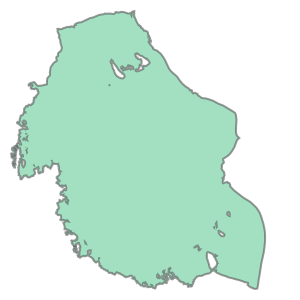

In [4]:
tmp = xopr.geometry.get_antarctic_regions(regions='West', merge_regions=True)
xopr.geometry.project_geojson(tmp)

The MEaSUREs dataset categorizes regions as `GR` (grounded), `FL` (floating), or `IS` (island). You can select by those:

Area is 1527034.4 km^2, automatically applying 1km simplification tolerance
To disable simplification, set simplify_tolerance=0


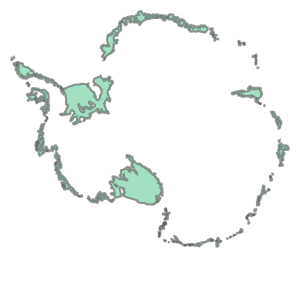

In [5]:
tmp = xopr.geometry.get_antarctic_regions(type='FL', merge_regions=True)
xopr.geometry.project_geojson(tmp)

You can also select by name. Note that you can pass a list to any of these parameters, as shown here.

By default `merge_regions=True` and the return value is a single GeoJSON geometry. If you set `merge_regions=False`, you'll instead get back a GeoDataFrame with information about the regions included.

```{tip}
If you're trying to figure out what parameters to use to find your region, the [user guide for the MEaSUREs data product](https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf) may be useful.

[Quantarctica](https://www.npolar.no/quantarctica/) also includes this layer under the "glaciology" category if you want to be able to browse around and see the regions.
```


In [6]:
xopr.geometry.get_antarctic_regions(name=['LarsenD', 'LarsenE'], merge_regions=False)

,NAME,Regions,Subregions,TYPE,Asso_Shelf,geometry
0,LarsenE,Peninsula,Ipp-J,GR,LarsenE,"MULTIPOLYGON (((-60.39436 -73.13624, -60.38126..."
157,LarsenD,Peninsula,Ipp-J,GR,LarsenD,"MULTIPOLYGON (((-64.95333 -69.41766, -64.9344 ..."
196,LarsenD,Peninsula,None,FL,None,"MULTIPOLYGON (((-61.05159 -68.70734, -61.02381..."
351,LarsenE,Peninsula,None,FL,None,"MULTIPOLYGON (((-60.74551 -73.68418, -60.77062..."


For the rest of this notebook, we're going to look at just the Dotson ice shelf, which we select as follows:

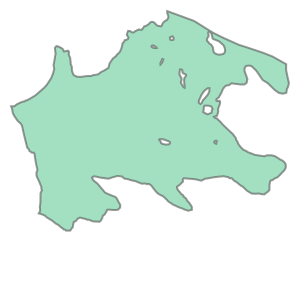

In [7]:
region = xopr.geometry.get_antarctic_regions(name="Dotson", type="FL", merge_regions=True)
xopr.geometry.project_geojson(region)

Here we see a new way of searching for radar frames by geometry. Simply passing our GeoJSON region gives us every available frame that intersects it.

`data_product` controls what you get back. If you set this to `CSARP_standard` (or another `CSARP_` standard data product), you'll get back a list of loaded radar frames. If you set it to `None`, you'll get back the actual STAC items. That's helpful here because we're going to distribute the process of analyzing these frames, so we don't actually want to load any data just yet.

Passing `max_items=10` limits the search to a maximum of 10 items to keep this running quickly on the GitHub Actions runners, but feel free to experiment with removing it.

In [8]:
#stac_items = opr.search_by_geometry(region, data_product=None, max_items=10)
stac_items = opr.query_frames(geometry=region, max_items=10)

Plotting a map should look familiar. Here we've also overlaid the region we're searching.

You'll notice that the region doesn't quite line up with the GeoViews `coastline` feature. That's expected. The coastline feature is a relatively low resolution global data product that you shouldn't treat as a real grounding line.

In [9]:
# Plot a map of our loaded data over the selected region on an EPSG:3031 projection

# Create a GeoViews object for the selected region
region_gv = gv.Polygons(region, crs=latlng).opts(
    color='green',
    line_color='black',
    fill_alpha=0.5,
    projection=epsg_3031,
)
# Plot the frame geometries
frame_lines = []
for item in stac_items.geometry:
    frame_lines.append(gv.Path(item, crs=latlng).opts(
        line_width=2,
        projection=epsg_3031
    ))

(features * region_gv * gv.Overlay(frame_lines)).opts(projection=epsg_3031)

:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]
   .Path.II     :Path   [Longitude,Latitude]
   .Path.III    :Path   [Longitude,Latitude]
   .Path.IV     :Path   [Longitude,Latitude]
   .Path.V      :Path   [Longitude,Latitude]
   .Path.VI     :Path   [Longitude,Latitude]
   .Path.VII    :Path   [Longitude,Latitude]
   .Path.VIII   :Path   [Longitude,Latitude]
   .Path.IX     :Path   [Longitude,Latitude]
   .Path.X      :Path   [Longitude,Latitude]

Now that we've picked out some data, we're going to define some functions to do some simple analysis on it. We won't explain every detail of the code below, but basically it's picking out the surface and bed reflection powers and giving us back a `Dataset` with those powers in decibels.

In [10]:
def extract_layer_peak_power(radar_ds, layer_twtt, margin_twtt):
    """
    Extract the peak power of a radar layer within a specified margin around the layer's two-way travel time (TWTT).

    Parameters:
    - radar_ds: xarray Dataset containing radar data.
    - layer_twtt: The two-way travel time of the layer to extract.
    - margin_twtt: The margin around the layer's TWTT to consider for peak power extraction.

    Returns:
    - A DataArray containing the peak power values for the specified layer.
    """
    
    # Ensure that layer_twtt.slow_time matches the radar_ds slow_time
    t_start = np.minimum(radar_ds.slow_time.min(), layer_twtt.slow_time.min())
    t_end = np.maximum(radar_ds.slow_time.max(), layer_twtt.slow_time.max())
    layer_twtt = layer_twtt.sel(slow_time=slice(t_start, t_end))
    radar_ds = radar_ds.sel(slow_time=slice(t_start, t_end))
    #layer_twtt = layer_twtt.interp(slow_time=radar_ds.slow_time, method='nearest')
    layer_twtt = layer_twtt.reindex(slow_time=radar_ds.slow_time, method='nearest', tolerance=pd.Timedelta(seconds=1), fill_value=np.nan)
    
    # Calculate the start and end TWTT for the margin
    start_twtt = layer_twtt - margin_twtt
    end_twtt = layer_twtt + margin_twtt
    
    # Extract the data within the specified TWTT range
    data_within_margin = radar_ds.where((radar_ds.twtt >= start_twtt) & (radar_ds.twtt <= end_twtt), drop=True)

    power_dB = 10 * np.log10(np.abs(data_within_margin.Data))

    # Find the twtt index corresponding to the peak power
    peak_twtt_index = power_dB.argmax(dim='twtt')
    # Convert the index to the actual TWTT value
    peak_twtt = power_dB.twtt[peak_twtt_index]

    # Calculate the peak power in dB
    peak_power = power_dB.isel(twtt=peak_twtt_index)

    # Remove unnecessary dimensions
    peak_twtt = peak_twtt.drop_vars('twtt')
    peak_power = peak_power.drop_vars('twtt')
    
    return peak_twtt, peak_power

def surface_bed_reflection_power(stac_item, opr=xopr.opr_access.OPRConnection()):

    frame = opr.load_frame(stac_item, data_product='CSARP_standard')
    frame = frame.resample(slow_time='5s').mean()

    try:
        layers = opr.get_layers_db(frame, include_geometry=False)
    except Exception as e:
        print(f"Error retrieving layers: {e}")
        return None
    
    # Re-pick surface and bed layers to ensure we're getting the peaks
    speed_of_light_in_ice = scipy.constants.c / np.sqrt(3.17)  # Speed of light in ice (m/s)
    layer_selection_margin_twtt = 50 / speed_of_light_in_ice # approx 50 m margin in ice
    surface_repicked_twtt, surface_power = extract_layer_peak_power(frame, layers["standard:surface"]['twtt'], layer_selection_margin_twtt)
    bed_repicked_twtt, bed_power = extract_layer_peak_power(frame, layers["standard:bottom"]['twtt'], layer_selection_margin_twtt)

    # Create a dataset from surface_repicked_twtt, bed_repicked_twtt, surface_power, and bed_power

    reflectivity_dataset = xr.merge([
        surface_repicked_twtt.rename('surface_twtt'),
        bed_repicked_twtt.rename('bed_twtt'),
        surface_power.rename('surface_power_dB'),
        bed_power.rename('bed_power_dB'),
        ])

    flight_line_metadata = frame.drop_vars(['Data', 'Surface', 'Bottom'])
    reflectivity_dataset = xr.merge([reflectivity_dataset, flight_line_metadata])

    reflectivity_dataset = reflectivity_dataset.drop_dims(['twtt'])  # Remove the twtt dimension since everything has been flattened

    attributes_to_copy = ['season', 'segment', 'doi', 'ror', 'funder_text']
    reflectivity_dataset.attrs = {attr: frame.attrs[attr] for attr in attributes_to_copy if attr in frame.attrs}

    return reflectivity_dataset

Let's try out our analysis function on one frame. The plot below shows surface and bed power for a single frame of radar data.

/home/m484s199/miniconda3/envs/py312/lib/python3.12/site-packages/xopr/opr_access.py:353: UserWarning: Warning: Unexpected result from ops_api: ERROR: SEGMENT DOES NOT EXIST.
  warnings.warn(f"Warning: Unexpected result from ops_api: {result['data']}", UserWarning)


Error retrieving layers: Task 5b86670becc944f1b5b9341cfb3f4baa timed out after 200 seconds.


TypeError: 'NoneType' object is not subscriptable

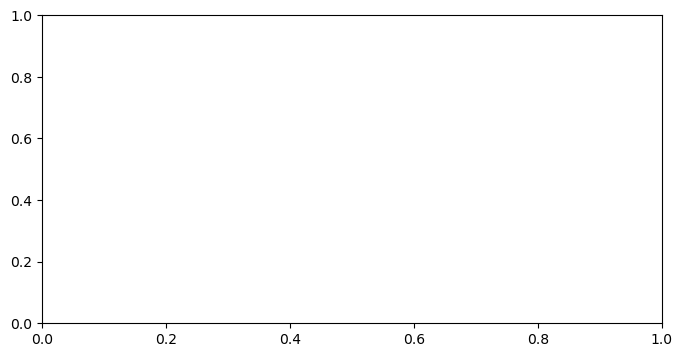

In [11]:
reflectivity = surface_bed_reflection_power(stac_items.iloc[0], opr=opr)

fig, ax = plt.subplots(figsize=(8, 4))
reflectivity['surface_power_dB'].plot(ax=ax, x='slow_time', label='Surface')
reflectivity['bed_power_dB'].plot(ax=ax, x='slow_time', label='Bed')
ax.set_ylabel('Power [dB]')
ax.legend()
plt.show()

In [13]:
stac_items.iloc[0]['assets']

{'CSARP_standard': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/CSARP_standard/20021212_01/Data_20021212_01_003.mat',
  'type': 'application/x-matlab-data'},
 'data': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/CSARP_standard/20021212_01/Data_20021212_01_003.mat',
  'type': 'application/x-matlab-data'},
 'flight_path': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/images/20021212_01/20021212_01_003_0maps.jpg',
  'type': 'image/jpeg'},
 'thumbnails': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/images/20021212_01/20021212_01_003_2echo_picks.jpg',
  'type': 'image/jpeg'}}

Ok, that works, so now let's scale up. You could just write a loop, but this is a parallelizable task, so we want to share the load out across whatever computational resources you might have.

This is good time to pause and note a few things:

```{admonition} This is getting too complicated!
We're about to jump into how to parallelize your workflows. This part is *completely optional*. If you're happily doing your analysis without thinking about this, you can feel free to ignore the rest of the tutorial.

But if you're curious or you'd like to run things faster...
```

If you're still with us, this would probably be a good time to briefly read up on [Dask](https://www.dask.org/). In short, Dask gives us a way to write code that looks pretty close to standard Python code but also easily distribute jobs across available compute infrastructure.

The defaults in this notebook will simply parallelize this workflow across however many CPU cores you have on your machine. We'll also discuss using [Coiled](https://coiled.io/) to scale your workflows into the cloud.

There are many more options, which you can read about in [the Dask documentation](https://docs.dask.org/en/stable/deploying.html). These options allow you to distribute your workflow across various cloud services or using any HPC resources you may have acesss to.

Getting started, we'll create a Dask `LocalCluster`, which is just going to let us distribute the workload across the CPUs on our machine:

In [ ]:
import dask
from dask.distributed import LocalCluster

client = LocalCluster().get_client()

We could have alternatively created any cluster we want. For example, this is how you'd create a Coiled cluster:

In [15]:
# import dask
# import coiled
# cluster = coiled.Cluster(n_workers=10)
# client = cluster.get_client()

Now we're going to use `client.map` to run our function across whatever resources are in the `client` object.

Note that if you're using a cloud cluster, you probably don't want to pass your local `opr` object. Since you don't have shared storage anyway, it'll be better to let it load a default `OPRConnection()` object on each worker.

In [16]:
stac_list = [row for _, row in stac_items.iterrows()]
futures = client.map(surface_bed_reflection_power, stac_list, opr=opr)

# Process results as they complete, capturing exceptions
results = []
for future in dask.distributed.as_completed(futures):
    try:
        result = future.result()
        results.append(result)
    except Exception as e:
        print(traceback.format_exc())

/home/m484s199/miniconda3/envs/py312/lib/python3.12/site-packages/xopr/opr_access.py:353: UserWarning: Warning: Unexpected result from ops_api: ERROR: SEGMENT DOES NOT EXIST.
  warnings.warn(f"Warning: Unexpected result from ops_api: {result['data']}", UserWarning)
/home/m484s199/miniconda3/envs/py312/lib/python3.12/site-packages/xopr/opr_access.py:353: UserWarning: Warning: Unexpected result from ops_api: ERROR: SEGMENT DOES NOT EXIST.
  warnings.warn(f"Warning: Unexpected result from ops_api: {result['data']}", UserWarning)
/home/m484s199/miniconda3/envs/py312/lib/python3.12/site-packages/xopr/opr_access.py:353: UserWarning: Warning: Unexpected result from ops_api: ERROR: SEGMENT DOES NOT EXIST.
  warnings.warn(f"Warning: Unexpected result from ops_api: {result['data']}", UserWarning)


Great! If that ran successfully, results should now be a list of `Dataset`'s. Now we're back to normal code to visualize our results.

In [17]:
# Create a GeoViews object for the selected region
region_gv = gv.Polygons(region, crs=latlng).opts(
    line_color='black',
    fill_alpha=0,
    projection=epsg_3031,
)

data_lines = []
for ds in results:
    ds['bed_minus_surf'] = ds['bed_power_dB'] - ds['surface_power_dB']
    ds = ds.dropna(dim='slow_time')
    ds = xopr.geometry.project_dataset(ds, target_crs='EPSG:3031')
    sc = ds.hvplot.scatter(x='x', y='y', c='bed_minus_surf',
                           hover_cols=['surface_power_dB', 'bed_power_dB'],
                           cmap='turbo', size=3)
    data_lines.append(sc)

(features * region_gv * gv.Overlay(data_lines)).opts(aspect='equal')

TypeError: 'NoneType' object is not subscriptable

If you're using a cloud or HPC cluster, it's good practice to explicitly close it. In most cases, it'll have an auto-timeout, but we'll just close ours to be safe.

In [ ]:
#cluster.close()

Congrats! If you made it this far, you've learned how to parallelize your radar analysis workflows!

In [18]:
results

[None, None, None, None, None, None, None, None, None, None]

In [20]:
stac_items.iloc[0]['assets']

{'CSARP_standard': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/CSARP_standard/20021212_01/Data_20021212_01_003.mat',
  'type': 'application/x-matlab-data'},
 'data': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/CSARP_standard/20021212_01/Data_20021212_01_003.mat',
  'type': 'application/x-matlab-data'},
 'flight_path': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/images/20021212_01/20021212_01_003_0maps.jpg',
  'type': 'image/jpeg'},
 'thumbnails': {'href': 'https://data.cresis.ku.edu/data/rds/2002_Antarctica_P3chile/images/20021212_01/20021212_01_003_2echo_picks.jpg',
  'type': 'image/jpeg'}}